# MNIST keras model

This notebook is part of this [post](https://www.stupid-projects.com/machine-learning-on-embedded-part-1) which is part a series of post about using ML and NN in embedded MCUs.

I've taken this notebook has been taken from this github repo and just added a few stuff:
https://github.com/fchollet/deep-learning-with-python-notebooks

## Additions
You don't have to use all the notebook. The first part is only if you want to train again your model. Currently the trained model is already part of the stm32f746 firmware. In the last part I've added a small part of code that you can draw a digit and then send it to the stm32f746 and get back the prediction.


In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 5.1 - Introduction to convnets

This notebook contains the code sample found in Chapter 5, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

First, let's take a practical look at a very simple convnet example. We will use our convnet to classify MNIST digits, a task that you've already been 
through in Chapter 2, using a densely-connected network (our test accuracy then was 97.8%). Even though our convnet will be very basic, its 
accuracy will still blow out of the water that of the densely-connected model from Chapter 2.

The 6 lines of code below show you what a basic convnet looks like. It's a stack of `Conv2D` and `MaxPooling2D` layers. We'll see in a 
minute what they do concretely.
Importantly, a convnet takes as input tensors of shape `(image_height, image_width, image_channels)` (not including the batch dimension). 
In our case, we will configure our convnet to process inputs of size `(28, 28, 1)`, which is the format of MNIST images. We do this via 
passing the argument `input_shape=(28, 28, 1)` to our first layer.

In [4]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


Let's display the architecture of our convnet so far:

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


You can see above that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The width 
and height dimensions tend to shrink as we go deeper in the network. The number of channels is controlled by the first argument passed to 
the `Conv2D` layers (e.g. 32 or 64).

The next step would be to feed our last output tensor (of shape `(3, 3, 64)`) into a densely-connected classifier network like those you are 
already familiar with: a stack of `Dense` layers. These classifiers process vectors, which are 1D, whereas our current output is a 3D tensor. 
So first, we will have to flatten our 3D outputs to 1D, and then add a few `Dense` layers on top:

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

We are going to do 10-way classification, so we use a final layer with 10 outputs and a softmax activation. Now here's what our network 
looks like:

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

As you can see, our `(3, 3, 64)` outputs were flattened into vectors of shape `(576,)`, before going through two `Dense` layers.

Now, let's train our convnet on the MNIST digits. We will reuse a lot of the code we have already covered in the MNIST example from Chapter 
2.

In [8]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [9]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
60000/60000 [==============================] - 10s 170us/step - loss: 0.1826 - acc: 0.9413
Epoch 2/5
60000/60000 [==============================] - 10s 166us/step - loss: 0.0463 - acc: 0.9857
Epoch 3/5
60000/60000 [==============================] - 10s 165us/step - loss: 0.0321 - acc: 0.9902
Epoch 4/5
60000/60000 [==============================] - 10s 165us/step - loss: 0.0254 - acc: 0.9923
Epoch 5/5
60000/60000 [==============================] - 10s 164us/step - loss: 0.0196 - acc: 0.9940


Let's evaluate the model on the test data:

In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 65us/step


In [11]:
test_acc

0.9905

While our densely-connected network from Chapter 2 had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we 
decreased our error rate by 68% (relative). Not bad! 

In [12]:
model.save('mnist.h5')

In [13]:
model.save('mnist_no_optimizer.h5', include_optimizer=False)

In [65]:
train_images.shape

(60000, 28, 28, 1)

In [110]:
from matplotlib import pyplot as plt
from tkinter import *
from stm32comms.MnistDigitDraw import MnistDigitDraw

In [ ]:
root = Tk()
d = MnistDigitDraw(root, 250, 250)
d.start()
root.mainloop()

In [112]:
import numpy as np

In [118]:
digit = np.loadtxt('stm32comms/digit2.txt')

In [119]:
x = digit.reshape(28,28)
x = np.expand_dims(x, axis=0)
x = np.expand_dims(x, axis=3)

In [120]:
x.shape

(1, 28, 28, 1)

In [121]:
model.predict(x)

array([[6.2229915e-09, 2.4238827e-06, 4.4001154e-06, 9.9604118e-01,
        7.8605096e-09, 3.9505456e-03, 5.8800081e-10, 3.4948805e-08,
        1.1089737e-06, 2.8340074e-07]], dtype=float32)

In [122]:
num = train_images[0]
num = np.expand_dims(num, axis=0)
model.predict(num)

array([[3.7969732e-14, 3.3321804e-11, 7.7299261e-15, 1.8763968e-06,
        2.0775243e-14, 9.9999809e-01, 1.1126530e-10, 2.4182195e-12,
        5.9399077e-09, 2.2940748e-08]], dtype=float32)

In [123]:
def display_img(img):
    img = np.array(img, dtype='float')
    pixels = img.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

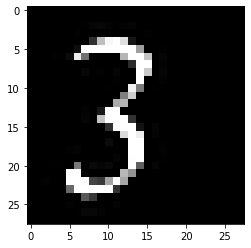

In [127]:
display_img(x)

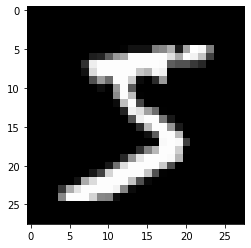

In [109]:
display_img(num)